In [3]:
# libraries

import matplotlib.pyplot as plt
import intake
import dask
from xmip.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon
%matplotlib inline

In [29]:
# data

url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

In [ ]:
# SSP scenarios that have >40 models and IPCC uses
# ssp126 is SSP1-2.6 which is a 2 degree warming scenario (42 models)
# ssp245 is SSP2-4.5 which is about RCP4.5 (44 models)
# ssp370 is SSP3-7.0 which is a medium-high warming scenario (40 models)
# ssp585 is SSP5-8.5 which is a high warming scenario similar to RCP 8.5 (47 models)

In [ ]:
# test to find which models we have data for under ssp5-8.5

query_test = dict(experiment_id='ssp585',
                  variable_id=['ua', 'va'],
)

cat_test = col.search(**query_test)
print(cat_test.df['source_id'].unique())

['BCC-CSM2-MR' 'CanESM5' 'CanESM5-CanOE' 'UKESM1-0-LL' 'AWI-CM-1-1-MR'
 'MRI-ESM2-0' 'MIROC6' 'CAMS-CSM1-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR'
 'NESM3' 'MCM-UA-1-0' 'FGOALS-g3' 'NorESM2-LM' 'NorESM2-MM' 'ACCESS-CM2'
 'HadGEM3-GC31-LL' 'GISS-E2-1-G' 'GISS-E2-1-H' 'FIO-ESM-2-0' 'CESM2-WACCM'
 'HadGEM3-GC31-MM' 'CESM2' 'CMCC-CM2-SR5' 'TaiESM1' 'IITM-ESM'
 'MIROC-ES2L' 'CAS-ESM2-0' 'CMCC-ESM2' 'ACCESS-ESM1-5']


In [ ]:
# load some data for GFDL-CM4 and CanESM5

query = dict(experiment_id='ssp585',
             variable_id=['ua', 'va'],
             source_id=['GFDL-CM4', 'CanESM5', 'IPSL-CM5A2-INCA', 'EC-Earth3'],
             table_id='day'
            )

cat = col.search(**query)
print(cat.df['source_id'].unique())

# load data into dictionary
# keys are constructed as 'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

z_kwargs = {'consolidated': True, 'decode_times':True}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=combined_preprocessing)

NameError: name 'col' is not defined

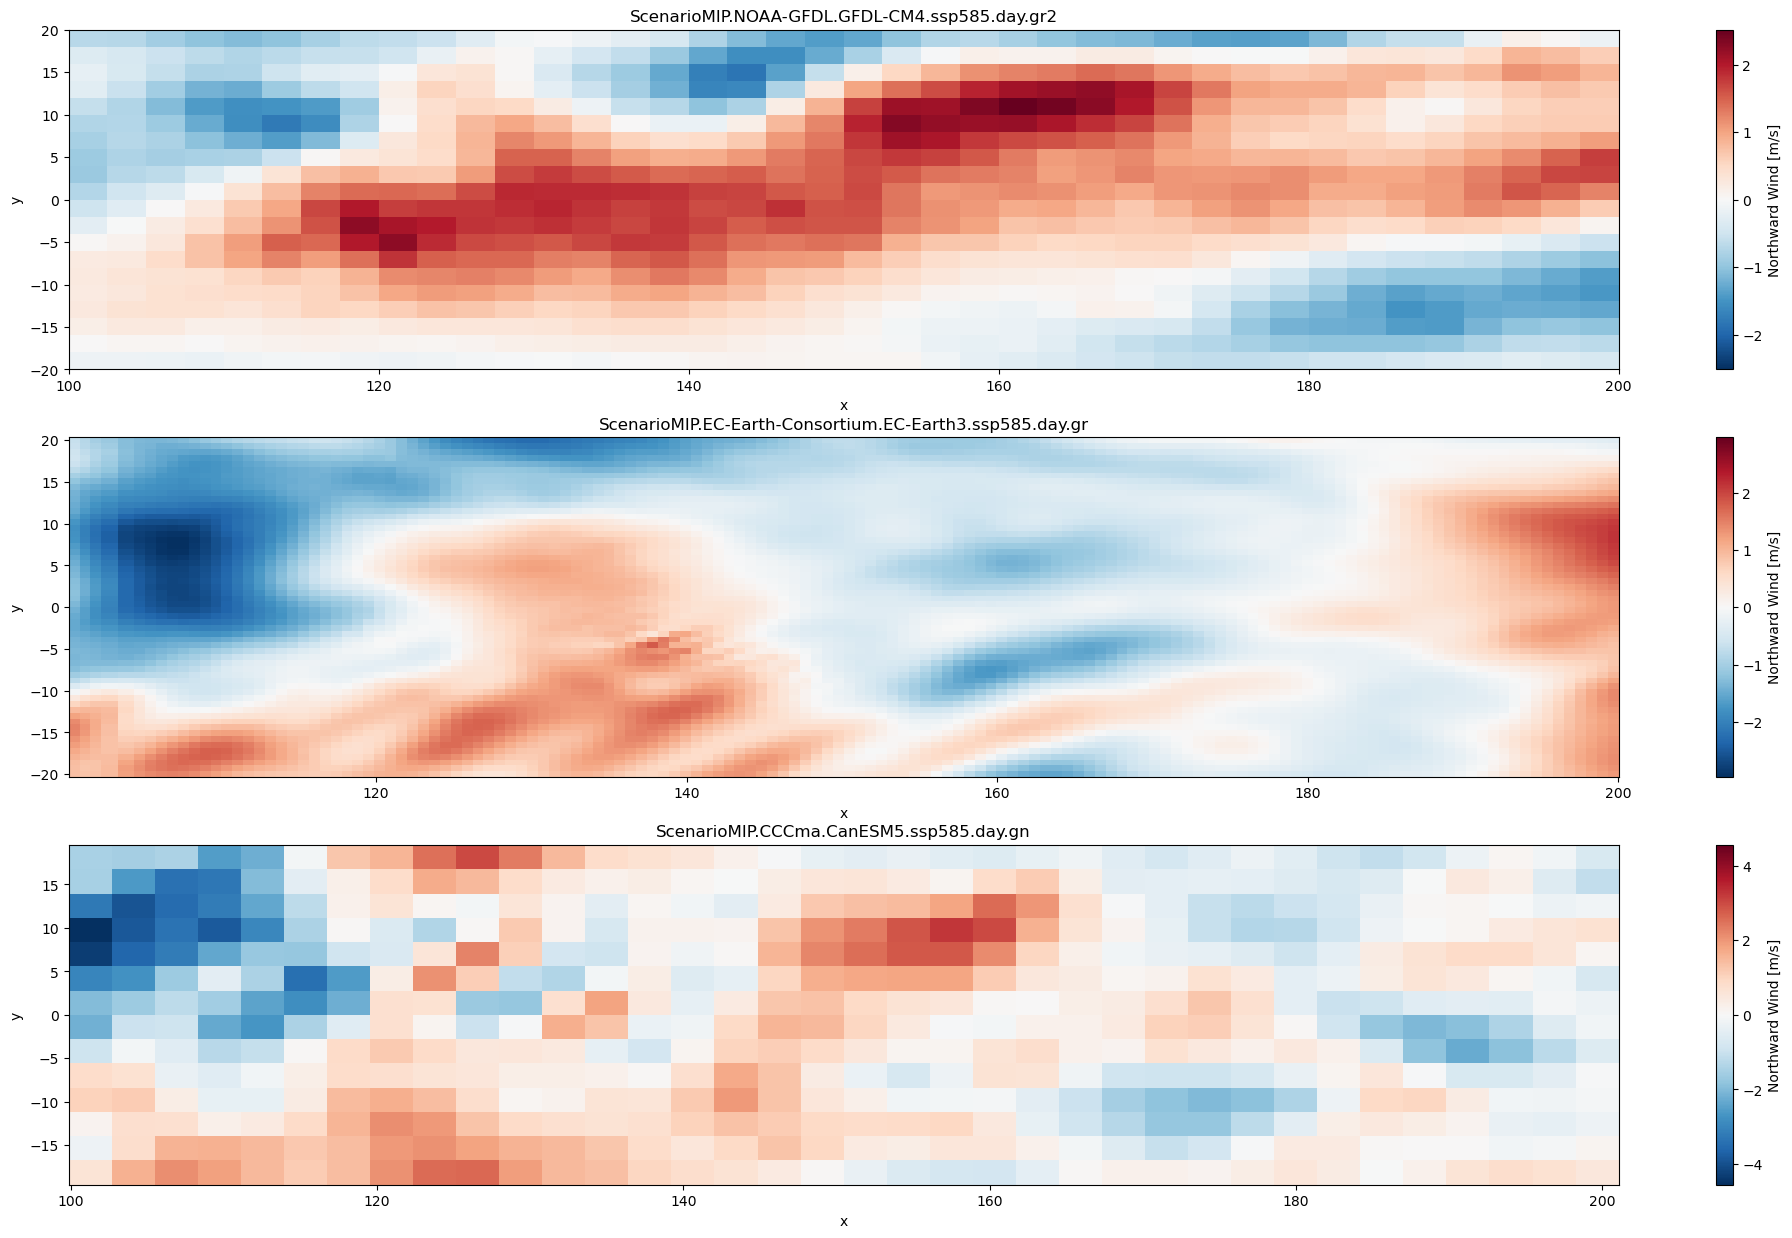

In [ ]:
# plots maps

fig, axarr = plt.subplots(nrows=3, ncols=1, figsize=[25,15])
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    da = ds.va.isel(time=0).interp(plev=2000)

    da = replace_x_y_nominal_lat_lon(da)
    da = da.sel(x=slice(100, 200), y=slice(-20,20))
    try:
        da.plot(ax=ax)
    except:
        print(k)
        pass
    ax.set_title(k)

In [44]:
# show coordinates

for k, ds in dset_dict.items():
    print(k)
    print(list(ds.dims))

ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp585.day.gr2
['y', 'x', 'plev', 'time', 'member_id', 'dcpp_init_year', 'bnds']
ScenarioMIP.CCCma.CanESM5.ssp585.day.gn
['member_id', 'dcpp_init_year', 'time', 'plev', 'y', 'x', 'bnds']


In [ ]:
dset_dict.items()

In [ ]:
list(dset_dict.keys())

In [ ]:
key = list(dset_dict.keys())[0]
ds = dset_dict[key]
ds

In [ ]:
ds['ua']

In [ ]:
test = ds['va'].isel(time=0)
test.mean(dim='lon').plot()

In [ ]:
test